# Imports

In [94]:
import os
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from cmcrameri import cm

# Set seeds
import random
random.seed(42)


data_path=  Path('../../../../../gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_spat_NH')
attributes_path = data_path / 'camels_spat_attributes_to_nh.csv'

# data_path =  Path('../../../../../gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_US')
# attributes_path = data_path / 'camels_attributes_v2.0'

data_path_camels_us = Path('../../../../../gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_US')
map_shape_file = data_path_camels_us / 'basin_set_full_res/usa-states-census-2014.shp'
hm_catchment = data_path_camels_us / 'basin_set_full_res/HCDN_nhru_final_671.shp'



# Parameters and constants

In [82]:
file_name = '569_basin_file.txt'

basin_file = Path(file_name)

stactic_camels_us = [
    'elev_mean',
    'slope_mean',
    'area_gages2',
    'frac_forest',
    'lai_max',
    'lai_diff',
    'gvf_max',
    'gvf_diff',
    'soil_depth_pelletier',
    'soil_depth_statsgo',
    'soil_porosity',
    'soil_conductivity',
    'max_water_content',
    'sand_frac',
    'silt_frac',
    'clay_frac',
    'carbonate_rocks_frac',
    'geol_permeability',
    'p_mean',
    'pet_mean',
    'aridity',
    'frac_snow',
    'high_prec_freq',
    'high_prec_dur',
    'low_prec_freq',
    'low_prec_dur',
    'p_seasonality'
]

stactic_camels_spat = [
    'aridity1_mean',
    'fracsnow1_mean',
    'seasonality1_mean',
    'low_prec_dur_mean',
    'high_prec_freq',
    'high_prec_dur_mean',
    'prec_mean',
    'pet_mean',
    'basin_area',
    'elev_mean',
    'slope_mean',
    'soil_thickness_mean',
    'porosity_mean',
    'log_permeability_mean',
    'lai_mean_month_max',
    'lai_mean_month_diff',
    'sand_layer_mean',
    'silt_layer_mean',
    'clay_layer_mean'
]

# Load data

In [85]:
# Load the basin list
with open(basin_file, 'r') as f:
    basins = f.read().splitlines()

# Check if attributes_path is a file or a directory
if attributes_path.is_file():
    # Load the CAMELS_spat attributes
    attrs_df = pd.read_csv(attributes_path)
    static_list = stactic_camels_spat
    attrs_df = attrs_df[['basin'] + static_list]
    ds_name = 'CAMELS-SPAT'
else:
    # Load the CAMELS attributes
    if not attributes_path.exists():
        raise RuntimeError(f"Attribute folder not found at {attributes_path}")

    txt_files = attributes_path.glob('camels_*.txt')

    # Read-in attributes into one big dataframe
    dfs = []
    for txt_file in txt_files:
        df_temp = pd.read_csv(txt_file, sep=';', header=0, dtype={'gauge_id': str})
        df_temp = df_temp.set_index('gauge_id')

        dfs.append(df_temp)

    attrs_df = pd.concat(dfs, axis=1)
    # convert huc column to double digit strings
    attrs_df['huc'] = attrs_df['huc_02'].apply(lambda x: str(x).zfill(2))
    attrs_df = attrs_df.drop('huc_02', axis=1)

    if basins:
        if any(b not in attrs_df.index for b in basins):
            raise ValueError('Some basins are missing static attributes.')
        attrs_df = attrs_df.loc[basins]

    # Remove index and Substitute gauge_id for basin
    attrs_df = attrs_df.reset_index().rename(columns={'gauge_id': 'basin'})

    # Filter the CAMELS static attributes
    static_list = stactic_camels_us
    attrs_df = attrs_df[['basin'] + static_list]
    ds_name = 'CAMELS-US'


# Filter the CAMELS spatial attributes to only include the basins in the basin list
attrs_df = attrs_df[attrs_df['basin'].isin(basins)]

display(
    # attrs_df.columns,
    attrs_df
)

,basin,aridity1_mean,fracsnow1_mean,seasonality1_mean,low_prec_dur_mean,high_prec_freq,high_prec_dur_mean,prec_mean,pet_mean,basin_area,elev_mean,slope_mean,soil_thickness_mean,porosity_mean,log_permeability_mean,lai_mean_month_max,lai_mean_month_diff,sand_layer_mean,silt_layer_mean,clay_layer_mean
970,01013500,0.323255,0.263914,0.131144,2.849375,17.589206,1.113617,1010.434737,239.519324,2249.524543,276.400336,4.708683,0.695780,0.158077,-14.707692,4.237068,3.900777,29.837864,31.546744,15.110833
971,01022500,-0.005095,0.165999,-0.059396,3.171188,19.959091,1.084077,1238.659375,282.653385,585.877617,99.707297,2.718555,0.000000,0.069167,-13.900000,4.812181,4.228743,40.291058,26.437894,11.027562
972,01030500,0.002999,0.217049,0.019607,3.024007,19.191961,1.098824,1058.344383,265.152066,3670.232830,173.811860,2.457479,0.000000,0.113953,-13.869768,4.741621,4.251189,32.240222,32.245241,12.646281
973,01031500,-0.004610,0.238275,0.029446,3.130263,19.575526,1.086692,1086.861931,258.371508,761.595306,303.749373,4.490743,0.000000,0.084839,-13.987097,4.863259,4.461315,39.231195,29.236935,9.717238
974,01047000,-0.004914,0.252078,0.035300,3.185864,19.164563,1.096395,1106.376918,257.922156,915.256174,377.344141,7.455338,0.000000,0.076125,-14.618750,4.937118,4.511137,40.216249,29.764592,9.115074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,14306500,0.160321,0.010263,-0.872629,5.207293,18.424830,1.380903,2296.238571,326.791094,857.798728,325.567889,17.587053,0.695855,0.092973,-13.397297,4.756426,3.255130,32.647086,27.432596,19.459114
1629,14309500,0.004136,0.058117,-0.918840,5.575639,19.895319,1.403158,1640.654494,363.310986,225.932607,739.864091,20.123505,0.625955,0.153846,-14.284615,4.182288,2.671913,25.312107,28.414839,23.543059
1630,14316700,0.233154,0.152021,-0.767864,4.798497,16.394279,1.294258,1592.417112,349.973797,587.671441,942.100100,20.797549,0.599041,0.124600,-13.148000,4.653633,3.278226,34.925531,27.094363,15.696824
1631,14325000,-0.005607,0.027194,-0.938428,5.612434,20.068681,1.380773,1871.774929,351.733574,442.658586,653.652266,17.227649,0.698917,0.173500,-14.440000,4.508547,2.798837,28.686560,28.100129,22.856641


# Clustering

## Prepare data

In [86]:
# Select the columns to be used for clustering - all but basin
X = attrs_df.drop(columns=['basin'])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Elbow curve

In [87]:
# Determine the optimal number of clusters using the Elbow method
sse = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

/home/ame805/neuralhydrology_fork/venv-nh/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ame805/neuralhydrology_fork/venv-nh/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ame805/neuralhydrology_fork/venv-nh/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ame805/neuralhydrology_fork/venv-nh/lib/python3.8/site-packages/sklearn/cluster/_kmeans.

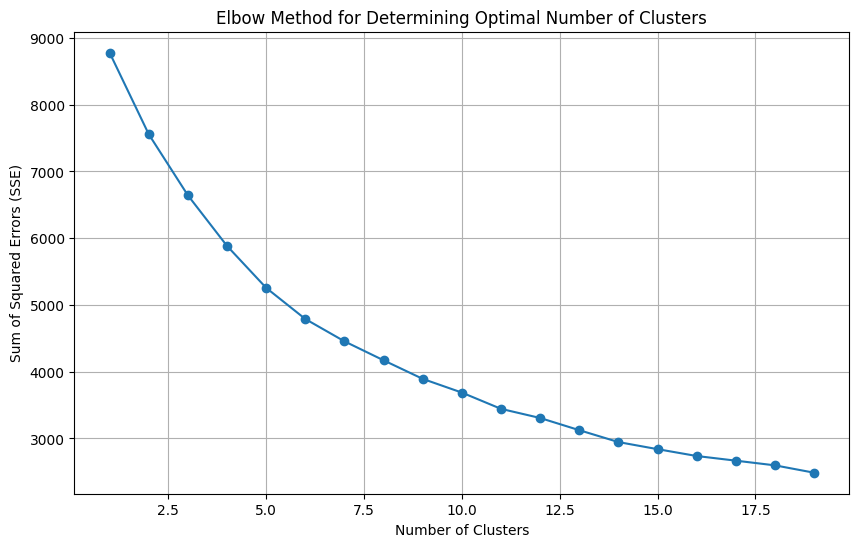

In [88]:
# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20, 1), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.grid(True)
plt.show()

## Silhouette score

In [89]:
# Determine the optimal number of clusters using the silhouette score
silhouette_scores = []
range_n_clusters = range(2, 21)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

/home/ame805/neuralhydrology_fork/venv-nh/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/ame805/neuralhydrology_fork/venv-nh/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ame805/neuralhydrology_fork/venv-nh/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ame805/neuralhydrology_fork/venv-nh/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ame805/neuralhydrology_fork/venv-nh/lib/python3.8/site-packages/sklearn/cluster/_kmeans.

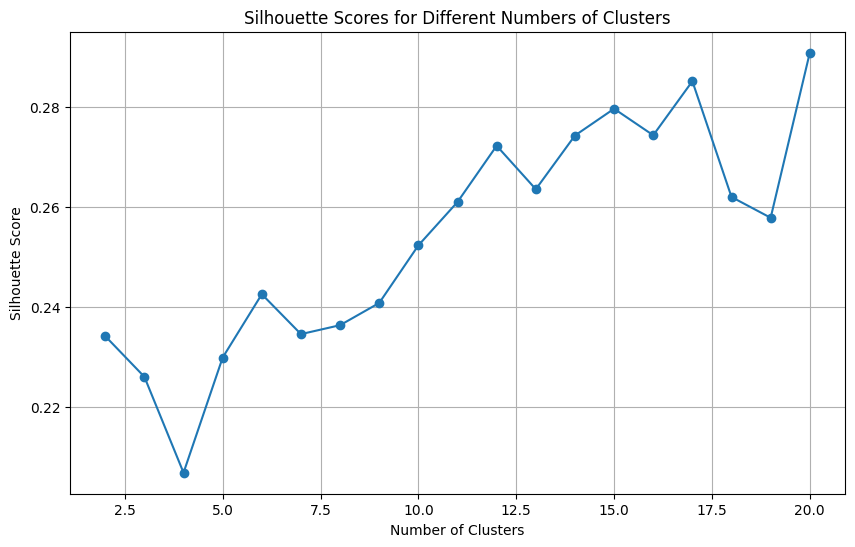

In [90]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.grid(True)
plt.show()

# K-means

In [91]:
# From the Elbow plot, choose the optimal number of clusters (e.g., k=4)
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
attrs_df['cluster'] = kmeans.fit_predict(X_scaled)

/home/ame805/neuralhydrology_fork/venv-nh/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Plot map

In [98]:
# Load basin coordinates (hm_catchment)
hm_catchment_gdf = gpd.read_file(hm_catchment)

# hru_id values to be string type of 8 characters with leading zeros
hm_catchment_gdf['hru_id'] = hm_catchment_gdf['hru_id'].astype(str).str.zfill(8)

# Filter hm_catchment_gdf to only include the HRU_IDs in the hm_catchment['basin'] column
hm_catchment_gdf = hm_catchment_gdf[hm_catchment_gdf['hru_id'].isin(attrs_df['basin'])]

In [100]:
states = gpd.read_file(map_shape_file)

# Define the CRS of your original data (if it's not already defined)
original_crs = 'EPSG:4326'  # Assuming WGS84 geographic CRS

states = gpd.read_file(map_shape_file)
# Set the CRS for the GeoDataFrame
states.crs = original_crs

# Define the new CRS you want to reproject to, for example, an Albers Equal Area projection
target_crs = 'ESRI:102008'  # ESRI:102008 is the WKID for the Albers Equal Area projection

# Reproject the GeoDataFrame
states_reprojected = states.to_crs(target_crs)

In [101]:
# Reproject the catchment GeoDataFrame
hm_catchment_gdf_reprojected = hm_catchment_gdf.to_crs(states_reprojected.crs)

# Reproject the coordinates of the circles
basin_coordinates_reprojected = gpd.points_from_xy(hm_catchment_gdf['lon_cen'], hm_catchment_gdf['lat_cen'], crs='EPSG:4326')
basin_coordinates_reprojected = gpd.GeoDataFrame(geometry=basin_coordinates_reprojected, crs='EPSG:4326')
basin_coordinates_reprojected = basin_coordinates_reprojected.to_crs(states_reprojected.crs)

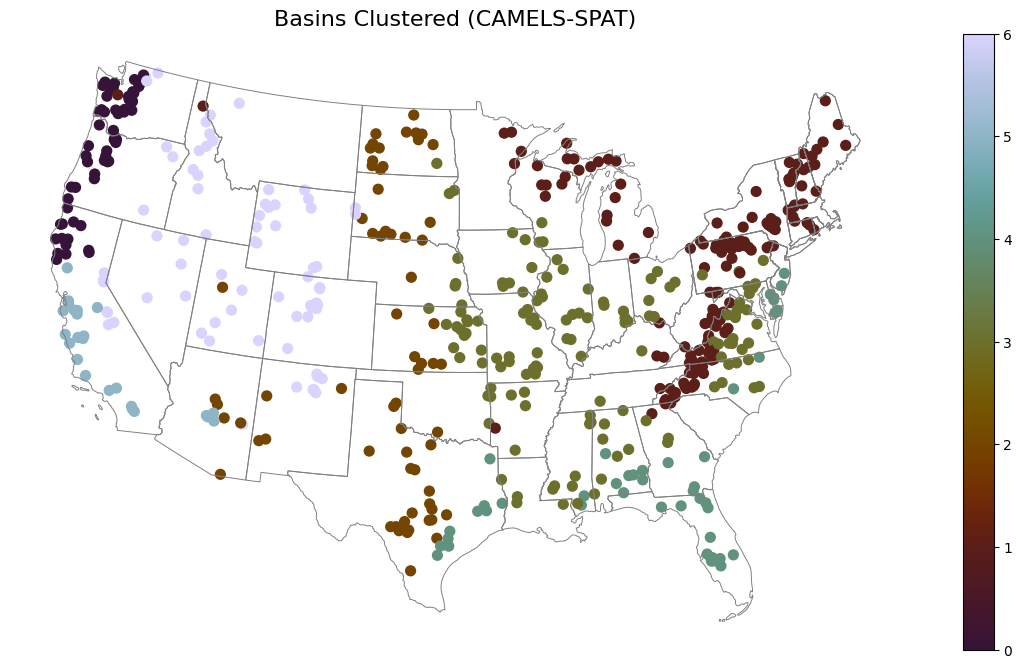

In [102]:
# Merge attrs_df with basin_coordinates_reprojected based on the index
basin_coordinates_reprojected['cluster'] = attrs_df['cluster'].values

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 8))

# Plot state boundaries
states_reprojected.boundary.plot(ax=ax, color=None, edgecolor='gray', linewidth=0.7)

# Create a discrete colormap
cmap = cm.glasgow  # Choose 'rain' or another colormap from cmocean

# Plot each basin as a circle with color determined by the cluster
basin_coordinates_reprojected.plot(ax=ax, marker='o', column='cluster', cmap=cmap, markersize=50, legend=True)

# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# Get rid of box lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add a title
plt.title(f'Basins Clustered ({ds_name})', fontsize=16)

# Show plot
plt.show()